# Pairing and Epipolar Geometry

Este notebook busca implementar a segunda etapa do projeto, focando em:
- Emparelhamento de características entre pares de imagens
- Estimação de matriz fundamental/essencial com RANSAC
- Recuperação de poses das câmeras (R, t)
- Triangulação de pontos 3D iniciais
- Visualização de linhas epipolares

## Setup do Notebook

In [131]:
import sys
sys.path.append('../../src')

from canon.utils import image_utils
from canon.T2.process import feature_extraction, epipolar_geometry
from canon.T2.plotting import visualization

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

print("Módulos importados com sucesso!")

Módulos importados com sucesso!


## Configuração do Experimento

In [ ]:
# Configurações
SELECTED_OBJECT = "galinha_honduras"  # Mudar para extrair características de outro objeto
MAX_PAIRS = 50  # Limitar número de pares para teste inicial
MIN_MATCHES = 30  # Mínimo de matches por par

print(f"Analisando objeto: {SELECTED_OBJECT}")
print(f"Máximo de pares: {MAX_PAIRS}")
print(f"Mínimo de matches por par: {MIN_MATCHES}")

Analisando objeto: msc_grandiosa_miniatura
Máximo de pares: 50
Mínimo de matches por par: 30


## Carregamento das Imagens e Características

In [133]:
# Carregar imagens
images = image_utils.load_images(f"T2/interim/{SELECTED_OBJECT}")
print(f"Carregadas {len(images)} imagens")

# Carregar características SIFT da Etapa 2
features_path = f"../../data/T2/interim/{SELECTED_OBJECT}/sift_features.pkl"

try:
    with open(features_path, 'rb') as f:
        saved_features = pickle.load(f)
    print(f"Características carregadas de: {features_path}")
    print(f"Características disponíveis para {len(saved_features)} imagens")
except FileNotFoundError:
    print(f"Arquivo de características não encontrado: {features_path}")
    print("Execute primeiro o notebook S2-1.0-hpbv-feature-extraction.ipynb")
    saved_features = None

Carregadas 100 imagens
Características carregadas de: ../../data/T2/interim/msc_grandiosa_miniatura/sift_features.pkl
Características disponíveis para 100 imagens


## Reconstrução das Características para OpenCV

In [134]:
# Reconstrói keypoints do formato salvo
def reconstruct_keypoints(kp_data):
    keypoints = []
    for pt, angle, size, response in kp_data:
        kp = cv2.KeyPoint(x=pt[0], y=pt[1], size=size, angle=angle, response=response)
        keypoints.append(kp)
    return keypoints

# Reconstrói features no formato esperado
if saved_features is not None:
    features = {}
    for img_name, data in saved_features.items():
        keypoints = reconstruct_keypoints(data['keypoints_data'])
        descriptors = data['descriptors']
        features[img_name] = (keypoints, descriptors)
    
    print(f"Características reconstruídas para {len(features)} imagens")
else:
    print("Extraindo características novamente...")
    # Fallback: extrai características novamente
    features_data = feature_extraction.extract_sift_for_3d(
        images, save_visualizations=False
    )
    features = {name: (data['keypoints'], data['descriptors']) 
               for name, data in features_data.items()}

Características reconstruídas para 100 imagens


## Configuração do Matcher

In [135]:
# Configura matcher
matcher = epipolar_geometry.ImagePairMatcher(
    matcher_type="BF",  # Brute Force
    ratio_threshold=0.75,
    cross_check=False  # Desabilitado para usar ratio test
)

print("Matcher configurado: Brute Force com Lowe's ratio test (0.75)")

Matcher configurado: Brute Force com Lowe's ratio test (0.75)


## Emparelhamento de Características

In [136]:
# Realiza emparelhamento
print("Iniciando emparelhamento...")

match_results = epipolar_geometry.match_image_collection(
    features=features,
    matcher=matcher,
    max_pairs=MAX_PAIRS,
    min_matches=MIN_MATCHES
)

print(f"\nEmparelhamento concluído!")
print(f"Pares bem-sucedidos: {len(match_results)}")

Iniciando emparelhamento...
Matching 50 image pairs...
  Progress: 0/50 pairs processed
  Progress: 10/50 pairs processed
  Progress: 20/50 pairs processed
  Progress: 30/50 pairs processed
  Progress: 40/50 pairs processed
Successfully matched 50/50 pairs

Emparelhamento concluído!
Pares bem-sucedidos: 50


## Visualização dos Resultados de Emparelhamento

In [ ]:
# Cria visualizações dos melhores pares
visualization.visualize_matching_results(
    match_results=match_results,
    images=images,
    save_pairs=5,  # 5 melhores pares
    save_path=f"T2/interim/{SELECTED_OBJECT}/S3-hpbv-feature-matching"
)

# Cria gráfico resumo
visualization.create_matching_summary_plot(
    match_results,
    save_path=f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-feature-matching/matching_summary.png"
)

Saved match visualization: matches_40_42_896matches
Saved match visualization: matches_70_72_839matches
Saved match visualization: matches_1_10_797matches
Saved match visualization: matches_11_15_706matches
Saved match visualization: matches_77_80_673matches
Matching summary saved to ../../data/T2/interim/msc_grandiosa_miniatura/ComparingMatchers/matching_summary.png

Matching Statistics:
Total pairs processed: 50
Average matches per pair: 244.7
Median matches per pair: 157.0
Max matches: 896
Min matches: 56


## Estimação de Geometria Epipolar

### Configuração da Câmera (Estimativa Inicial)

In [138]:
# Configura estimador de geometria epipolar
# Para início, assumimos câmera não calibrada (apenas matriz fundamental)

sample_img = list(images.values())[0]
h, w = sample_img.shape[:2]

fx = fy = max(w, h)  # Distância focal aproximada
cx, cy = w/2, h/2    # Centro da imagem

K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
], dtype=np.float32)

print(f"Matriz de câmera estimada:")
print(K)
print(f"Resolução da imagem: {w}x{h}")

# Cria estimador
epipolar_estimator = epipolar_geometry.EpipolarGeometryEstimator(
    camera_matrix=None,  # Começa sem calibração
    ransac_threshold=1.0,
    confidence=0.99
)

print("Estimador configurado para matriz fundamental (não calibrada)")

Matriz de câmera estimada:
[[1.28e+03 0.00e+00 3.60e+02]
 [0.00e+00 1.28e+03 6.40e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Resolução da imagem: 720x1280
Estimador configurado para matriz fundamental (não calibrada)


## Análise de Geometria Epipolar para Pares Selecionados

In [ ]:
# Analisa os 3 melhores pares
sorted_pairs = sorted(match_results.items(), 
                     key=lambda x: x[1]['num_matches'], 
                     reverse=True)

epipolar_results = {}

print("Analisando geometria epipolar para os melhores pares...")

for i, ((img1_name, img2_name), match_data) in enumerate(sorted_pairs[:3]):
    print(f"\n--- Par {i+1}: {img1_name} <-> {img2_name} ---")
    print(f"Matches: {match_data['num_matches']}")
    
    pts1 = match_data['pts1']
    pts2 = match_data['pts2']
    
    # Estima matriz fundamental
    F, mask_F = epipolar_estimator.estimate_fundamental_matrix(pts1, pts2)
    
    if F is not None:
        inliers_F = np.sum(mask_F)
        inlier_ratio = inliers_F / len(pts1)
        
        print(f"Matriz Fundamental: OK")
        print(f"Inliers: {inliers_F}/{len(pts1)} ({inlier_ratio:.2%})")
        
        # Salva resultados
        epipolar_results[(img1_name, img2_name)] = {
            'F': F,
            'mask_F': mask_F,
            'inliers_F': inliers_F,
            'inlier_ratio': inlier_ratio,
            'match_data': match_data
        }
        
        # Cria visualização com linhas epipolares
        img1 = images[img1_name]
        img2 = images[img2_name]
        
        visualization.save_epipolar_visualization(
            img1, img2, match_data, F, mask_F,
            f"{img1_name}_{img2_name}",
            save_path=f"T2/interim/{SELECTED_OBJECT}/S3-hpbv-epipolar-analysis"
        )
        
    else:
        print(f"Falha ao estimar matriz fundamental")

print(f"\nGeometria epipolar analisada para {len(epipolar_results)} pares")

Analisando geometria epipolar para os melhores pares...

--- Par 1: 40 <-> 42 ---
Matches: 896
Matriz Fundamental: OK
Inliers: 703/896 (78.46%)
Saved epipolar visualization: epipolar_40_42_703inliers

--- Par 2: 70 <-> 72 ---
Matches: 839
Matriz Fundamental: OK
Inliers: 660/839 (78.67%)
Saved epipolar visualization: epipolar_70_72_660inliers

--- Par 3: 1 <-> 10 ---
Matches: 797
Matriz Fundamental: OK
Inliers: 581/797 (72.90%)
Saved epipolar visualization: epipolar_1_10_581inliers

Geometria epipolar analisada para 3 pares


## Teste com Matriz Essencial (Câmera Calibrada)

In [140]:
# Cria estimador calibrado
calibrated_estimator = epipolar_geometry.EpipolarGeometryEstimator(
    camera_matrix=K,
    ransac_threshold=1.0,
    confidence=0.99
)

# Testa com o melhor par
if epipolar_results:
    best_pair = list(epipolar_results.keys())[0]
    img1_name, img2_name = best_pair
    
    print(f"Testando matriz essencial para: {img1_name} <-> {img2_name}")
    
    match_data = epipolar_results[best_pair]['match_data']
    pts1 = match_data['pts1']
    pts2 = match_data['pts2']
    
    # Estima matriz essencial
    E, mask_E = calibrated_estimator.estimate_essential_matrix(pts1, pts2)
    
    if E is not None:
        inliers_E = np.sum(mask_E)
        print(f"Matriz Essencial: OK")
        print(f"Inliers: {inliers_E}/{len(pts1)} ({inliers_E/len(pts1):.2%})")
        
        # Recupera pose
        num_pose_inliers, R, t, tri_mask = calibrated_estimator.recover_pose(
            E, pts1, pts2, mask_E
        )
        
        print(f"Pose recuperada:")
        print(f"Inliers de pose: {num_pose_inliers}")
        print(f"Rotação R:\n{R}")
        print(f"Translação t:\n{t.ravel()}")
        
        # Salva para triangulação
        pose_data = {
            'E': E,
            'R': R,
            't': t,
            'K': K,
            'mask_E': mask_E,
            'tri_mask': tri_mask
        }
        
    else:
        print("Falha ao estimar matriz essencial")
        pose_data = None
else:
    print("Nenhum resultado de geometria epipolar disponível")
    pose_data = None

Testando matriz essencial para: 40 <-> 42
Matriz Essencial: OK
Inliers: 773/896 (86.27%)
Pose recuperada:
Inliers de pose: 773
Rotação R:
[[ 0.98967941 -0.09702028  0.10545961]
 [ 0.09724057  0.99525619  0.00306322]
 [-0.10525653  0.00722335  0.99441887]]
Translação t:
[-0.94424623  0.16447759 -0.28521251]


## Triangulação 3D Inicial

Realizando triangulação 3D...
Triangulação concluída: 773 pontos 3D
Após filtragem: 773 pontos 3D
Distância mediana: 7.19
3D plot saved to ../../data/T2/interim/msc_grandiosa_miniatura/ComparingMatchers/triangulation_3d.png


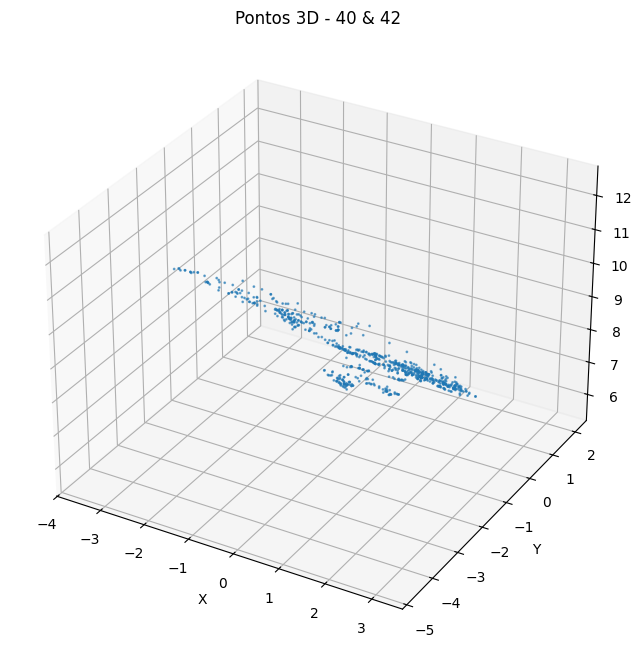

Pontos 3D salvos


In [ ]:
if pose_data is not None:
    print("Realizando triangulação 3D...")
    
    # Cria triangulador
    triangulator = epipolar_geometry.Triangulator(K)
    
    # Usa apenas inliers da matriz essencial
    mask_E = pose_data['mask_E']
    pts1_inliers = pts1[mask_E.ravel() == 1]
    pts2_inliers = pts2[mask_E.ravel() == 1]
    
    # Poses das câmeras
    R1 = np.eye(3)  # Primeira câmera na origem
    t1 = np.zeros(3)
    R2 = pose_data['R']
    t2 = pose_data['t'].ravel()
    
    # Triangula pontos 3D
    points_4d = triangulator.triangulate_points(
        pts1_inliers, pts2_inliers, R1, t1, R2, t2
    )
    
    # Converte para 3D
    points_3d = triangulator.convert_to_3d(points_4d)
    
    print(f"Triangulação concluída: {len(points_3d)} pontos 3D")
    
    # Filtra outliers
    distances = np.linalg.norm(points_3d, axis=1)
    median_dist = np.median(distances)
    valid_mask = distances < 3 * median_dist  # Remove pontos > 3x a mediana
    
    points_3d_filtered = points_3d[valid_mask]
    
    print(f"Após filtragem: {len(points_3d_filtered)} pontos 3D")
    print(f"Distância mediana: {median_dist:.2f}")
    
    # Visualiza pontos 3D
    if len(points_3d_filtered) > 0:
        visualization.plot_3d_points(
            points_3d_filtered,
            title=f"Pontos 3D - {img1_name} & {img2_name}",
            save_path=f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-reconstruction/triangulation_3d.png"
        )
        
        # Salva pontos 3D
        np.save(f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-reconstruction/points_3d.npy", points_3d_filtered)
        print(f"Pontos 3D salvos")
    else:
        print("Nenhum ponto 3D válido após filtragem")
        
else:
    print("Triangulação não realizada: dados de pose não disponíveis")

## Análise de Qualidade dos Resultados

In [142]:
# Resumo da qualidade
print(f"\nEmparelhamento:")
print(f"- Pares processados: {len(match_results)}")
print(f"- Matches médios por par: {np.mean([r['num_matches'] for r in match_results.values()]):.1f}")

if epipolar_results:
    print(f"\nGeometria Epipolar:")
    inlier_ratios = [r['inlier_ratio'] for r in epipolar_results.values()]
    print(f"- Pares com geometria válida: {len(epipolar_results)}")
    print(f"- Taxa de inliers média: {np.mean(inlier_ratios):.2%}")
    print(f"- Taxa de inliers mediana: {np.median(inlier_ratios):.2%}")

if 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
    print(f"\nTriangulação 3D:")
    print(f"- Pontos 3D triangulados: {len(points_3d_filtered)}")
    print(f"- Extent X: {points_3d_filtered[:, 0].min():.2f} a {points_3d_filtered[:, 0].max():.2f}")
    print(f"- Extent Y: {points_3d_filtered[:, 1].min():.2f} a {points_3d_filtered[:, 1].max():.2f}")
    print(f"- Extent Z: {points_3d_filtered[:, 2].min():.2f} a {points_3d_filtered[:, 2].max():.2f}")


Emparelhamento:
- Pares processados: 50
- Matches médios por par: 244.7

Geometria Epipolar:
- Pares com geometria válida: 3
- Taxa de inliers média: 76.67%
- Taxa de inliers mediana: 78.46%

Triangulação 3D:
- Pontos 3D triangulados: 773
- Extent X: -2.75 a 2.38
- Extent Y: -4.84 a 2.19
- Extent Z: 5.18 a 12.85


## Salvamento dos Resultados Finais

In [143]:
# Função para converter matches para formato serializável
def convert_matches_to_serializable(match_results):
    serializable_results = {}
    
    for pair, result in match_results.items():
        # Converte matches para lista de tuplas
        matches_data = []
        for match in result['matches']:
            matches_data.append({
                'queryIdx': match.queryIdx,
                'trainIdx': match.trainIdx, 
                'distance': match.distance
            })
        
        # Cria resultado serializável
        serializable_results[pair] = {
            'matches_data': matches_data,
            'pts1': result['pts1'],
            'pts2': result['pts2'],
            'num_matches': result['num_matches']
        }
    
    return serializable_results

# Função para limpar epipolar_results de objetos não serializáveis
def clean_epipolar_results(epipolar_results):
    clean_results = {}
    
    for pair, result in epipolar_results.items():
        clean_results[pair] = {
            'F': result['F'],
            'mask_F': result['mask_F'],
            'inliers_F': result['inliers_F'],
            'inlier_ratio': result['inlier_ratio'],
            # Remove match_data que contém objetos cv2.DMatch
            'num_matches': result['match_data']['num_matches'],
            'pts1': result['match_data']['pts1'],
            'pts2': result['match_data']['pts2']
        }
    
    return clean_results

# Converte resultados para formato serializável
print("Convertendo resultados para formato serializável...")

serializable_match_results = convert_matches_to_serializable(match_results)
clean_epipolar_data = clean_epipolar_results(epipolar_results)

# Prepara dados para salvamento
results_to_save = {
    'match_results': serializable_match_results,
    'epipolar_results': clean_epipolar_data,
    'camera_matrix': K,
    'selected_object': SELECTED_OBJECT,
    'parameters': {
        'max_pairs': MAX_PAIRS,
        'min_matches': MIN_MATCHES,
        'ratio_threshold': 0.75,
        'ransac_threshold': 1.0
    }
}

# Adiciona pose_data se disponível
if 'pose_data' in locals() and pose_data is not None:
    clean_pose_data = {
        'E': pose_data['E'],
        'R': pose_data['R'],
        't': pose_data['t'],
        'K': pose_data['K'],
        'mask_E': pose_data['mask_E'],
        'tri_mask': pose_data['tri_mask']
    }
    results_to_save['pose_data'] = clean_pose_data

# Salva
results_path = f"../../data/T2/interim/{SELECTED_OBJECT}/ComparingMatchers/etapa3_results.pkl"
with open(results_path, 'wb') as f:
    pickle.dump(results_to_save, f)

print(f"Resultados da Etapa 3 salvos em: {results_path}")
print(f"\nDados salvos:")
print(f"- Pares de matches: {len(serializable_match_results)}")
print(f"- Geometria epipolar: {len(clean_epipolar_data)} pares")
if 'pose_data' in locals() and pose_data is not None:
    print(f"- Dados de pose: disponíveis")
if 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
    print(f"- Pontos 3D triangulados: {len(points_3d_filtered)}")

Convertendo resultados para formato serializável...
Resultados da Etapa 3 salvos em: ../../data/T2/interim/msc_grandiosa_miniatura/ComparingMatchers/etapa3_results.pkl

Dados salvos:
- Pares de matches: 50
- Geometria epipolar: 3 pares
- Dados de pose: disponíveis
- Pontos 3D triangulados: 773
